In [49]:
# Initial imports
import warnings
warnings.filterwarnings('ignore')
import os
import requests
import pandas as pd
import numpy as np
from dotenv import load_dotenv
# Initialize the Panel Extensions (for Plotly)
import panel as pn
import param
pn.extension('plotly')
pn.extension()
import plotly.express as px
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv
import ipywidgets as widgets
from IPython.display import display
%matplotlib inline
#!pip install yfinance
import yfinance as yf
#!pip install pandas-montecarlo
import pandas_montecarlo
import datetime as dt
from MCForecastTools import MCSimulation
# Load .env enviroment variables
load_dotenv()



True

In [46]:
# Define Parameters
# Set number of simulations for MC
num_sims = 500
range_of_cryptos = ["BTC-USD", "ETH-USD", "BNB-USD", "ADA-USD", "DOGE-USD", "XRP-USD", "LINK-USD" , "THETA-USD", "LTC-USD", "XLM-USD"]
range_of_stocks = ["AMZN", "TSLA", "NEO", "AAPL", "NVDA", "BABA", "NFLX", "DIS", "NKE"]

# Define Functions

#CALCULATE 1 YEARS BACK DATE
def calc_1years_backdate():
    end = dt.datetime.now().date()
    start = end - dt.timedelta(days=365)
    return start
#CALCULATE 2 YEARS BACK DATE
def calc_2years_backdate():
    end = dt.datetime.now().date()
    start = end - dt.timedelta(days=730)
    return start
#CALCULATE 3 YEARS BACK DATE
def calc_3years_backdate():
    end = dt.datetime.now().date()
    start = end - dt.timedelta(days=1095)
    return start


#download crypto data and stock data for 3 years
def download_cryptos_data():
    df = yf.download(range_of_cryptos, period = "3y", group_by = 'ticker', threads = True, progress=False)
    df = df.dropna().copy()
    return df

def download_stocks_data():
    df = yf.download(range_of_stocks, period = "3y", group_by = 'ticker', threads = True, progress=False)
    df = df.dropna().copy()
    return df




def cumulative_return_plot(df):
    cumulative_returns = (1 + df['Close'].pct_change()).cumprod()
    plot = cumulative_returns.hvplot.line(x="Date", rot=45, shared_axes=False).opts(yformatter="%.0f", width=500, xlabel="Time", ylabel="Price", title="Cumulative Return")
    return plot


def MA_plot(df):
    df["30MA"]=df[["Close"]].rolling(30).mean()
    df["60MA"]=df[["Close"]].rolling(60).mean()
    df["90MA"]=df[["Close"]].rolling(90).mean()
    df.dropna(inplace=True)
    plot = df[["Close", "30MA", "60MA", "90MA"]].hvplot.line(x="Date", rot=45, shared_axes=False).opts(yformatter="%.0f", width=500, xlabel="Date", ylabel="Price", title="Moving Average")
    
    
    return plot

##Monte Carlo plot:
##annual return function:
def daily_return_data(df):
    daily_return = df["Close"].pct_change()
    return daily_return
##Monte Carlo function:
def MC_100simulation_plot(df):
    mc = MCSimulation(
        portfolio_data = df,
        weights = "",
        num_simulation = 100,
        num_trading_days = 252*5
)

    return plot




In [53]:
mc = MCSimulation(
    portfolio_data = crypto_df,
    weights = "",
    num_simulation = 100,
    num_trading_days = 252*5
)
mc.portfolio_data.head()


BTC-USD                                                      \
                   Open         High          Low        Close    Adj Close   
Date                                                                          
2018-07-08  6857.799805  6885.910156  6747.979980  6773.879883  6773.879883   
2018-07-09  6775.080078  6838.680176  6724.339844  6741.750000  6741.750000   
2018-07-10  6739.209961  6767.740234  6320.720215  6329.950195  6329.950195   
2018-07-11  6330.770020  6444.959961  6330.470215  6394.709961  6394.709961   
2018-07-12  6396.779785  6397.100098  6136.419922  6228.810059  6228.810059   

                                     DOGE-USD                      ...  \
                Volume daily_return      Open      High       Low  ...   
Date                                                               ...   
2018-07-08  3386210048          NaN  0.002642  0.002671  0.002573  ...   
2018-07-09  3718129920    -0.004743  0.002612  0.002649  0.002595  ...   
2018-07-10  4052430080    -0.061082  0.002606  0.002623  0.002242  ...   
2018-07-11  3644859904     0.010231  0.002406  0.002475  0.002353  ...   
2018-07-12  3770170112    -0.025943  0.002395  0.002425  0.002244  ...   

             BNB-USD                          ADA-USD                      \
           Adj Close    Volume daily_return      Open      High       Low   
Date                                                                        
2018-07-08   13.9919  60275400          NaN  0.149953  0.151385  0.144762   
2018-07-09   13.6645  36874000    -0.023399  0.145345  0.146111  0.139948   
2018-07-10   12.7613  36507100    -0.066098  0.139729  0.140654  0.128792   
2018-07-11   12.7049  38867700    -0.004420  0.128801  0.133925  0.126466   
2018-07-12   12.0706  26008100    -0.049926  0.131560  0.131560  0.123154   

                                                       
               Close Adj Close    Volume daily_return  
Date                                                   
2018-07-08  0.145389  0.145389  48142400          NaN  
2018-07-09  0.139971  0.139971  42768500    -0.037266  
2018-07-10  0.128792  0.128792  62318800    -0.079867  
2018-07-11  0.131483  0.131483  50179700     0.020894  
2018-07-12  0.127181  0.127181  37623900    -0.032719  

[5 rows x 70 columns]

In [39]:
# Create a Title for the Dashboard

# Fetch initial data:
crypto_df = download_cryptos_data()
stock_df = download_stocks_data()
fetch_data_button = pn.widgets.Button(name='FETCH HISTORICAL DATA FROM YAHOO FINANCE!', button_type='success')
def update_data(event):
    crypto_df = download_cryptos_data()
    stock_df = download_stocks_data()
fetch_data_button.on_click(update_data)



# Define title and welcome text
title = "#Investment Projection Dasboard"
welcome = "This Dashboard provice a visual analysis of historial value for certain stock and cryptos"


#Create Widget Elements:
crypto_ticker = pn.widgets.Select(name='Crypto Tickes', options=range_of_cryptos)
crypto_year_slider = pn.widgets.IntSlider(name='Years of Crypto Data', start=1, end=3, step=1, value=1)
stock_ticker = pn.widgets.Select(name='Stock Tickers', options=range_of_stocks) 
stock_year_slider = pn.widgets.IntSlider(name='Years of Stock Data', start=1, end=3, step=1, value=1)

# Input for Historical data
#Crypto historical Data:
crypto_input = pn.Column(crypto_ticker, crypto_year_slider, align='center')
@pn.depends(crypto_ticker, crypto_year_slider)
def reactive_crypto_MAchart(crypto_ticker, crypto_year_slider):
    if crypto_year_slider == 1:
        return MA_plot(crypto_df[crypto_ticker].loc[calc_1years_backdate():dt.datetime.now().date()])
    elif crypto_year_slider == 2:
        return MA_plot(crypto_df[crypto_ticker].loc[calc_2years_backdate():dt.datetime.now().date()])
    else:
        return MA_plot(crypto_df[crypto_ticker])
    
@pn.depends(crypto_ticker, crypto_year_slider)
def reactive_crypto_cumulative(crypto_ticker, crypto_year_slider):
    if crypto_year_slider == 1:
        return cumulative_return_plot(crypto_df[crypto_ticker].loc[calc_1years_backdate():dt.datetime.now().date()])
    elif crypto_year_slider == 2:
        return cumulative_return_plot(crypto_df[crypto_ticker].loc[calc_2years_backdate():dt.datetime.now().date()])
    else:
        return cumulative_return_plot(crypto_df[crypto_ticker])
crypto_column = pn.Column(crypto_input, reactive_crypto_MAchart, reactive_crypto_cumulative)


#Stock historical Data:
stock_input = pn.Column(stock_ticker, stock_year_slider, align='center')
@pn.depends(stock_ticker, stock_year_slider)
def reactive_stock_MAchart(stock_ticker, stock_year_slider):
    if stock_year_slider == 1:
        return MA_plot(stock_df[stock_ticker].loc[calc_1years_backdate():dt.datetime.now().date()])
    elif stock_year_slider == 2:
        return MA_plot(stock_df[stock_ticker].loc[calc_2years_backdate():dt.datetime.now().date()])
    else:
        return MA_plot(stock_df[stock_ticker])

@pn.depends(stock_ticker, stock_year_slider)
def reactive_stock_cumulative(stock_ticker, stock_year_slider):
    if stock_year_slider == 1:
        return cumulative_return_plot(stock_df[stock_ticker].loc[calc_1years_backdate():dt.datetime.now().date()])
    elif stock_year_slider == 2:
        return cumulative_return_plot(stock_df[stock_ticker].loc[calc_2years_backdate():dt.datetime.now().date()])
    else:
        return cumulative_return_plot(stock_df[stock_ticker])
stock_column = pn.Column(stock_input, reactive_stock_MAchart, reactive_stock_cumulative)

historical_data_row = pn.Row(crypto_column, stock_column, width=1100)


#Input for your proforlio
crypto_investment_ticker = pn.widgets.Select(name='Crypto Tickes', options=range_of_cryptos)
crypto_investment = pn.widgets.FloatInput(name='Your Crypto Investment in USD', value=0)
crypto_future_slider = pn.widgets.IntSlider(name='Years of MC projection', start=2, end=5, step=3, value=2)

stock_investment_ticker = pn.widgets.Select(name='Stock Tickes', options=range_of_cryptos)
stock_investment = pn.widgets.FloatInput(name='Your Stock Investment in USD', value=0)
stock_future_slider = pn.widgets.IntSlider(name='Years of MC projection', start=2, end=5, step=3, value=2)

cal_crypto_MC_button = pn.widgets.Button(name='Calculate MC', button_type='danger')
#@pn.depends(crypto_investment_ticker)
#def calc_crypto_MC_data(crypto_investment_ticker):
    #
    #
    #
    #
#cal_crypto_MC_button.on_click(calc_crypto_MC_data)
cal_stock_MC_button = pn.widgets.Button(name='Calculate MC', button_type='danger')
#@pn.depends(stock_investment, stock_future_slider)
#def calc_stock_MC_data(event):
    #
    #CODING LINE HERE!
    #
    #
#cal_stock_MC_button.on_click(calc_stock_MC_data)

crypto_user_input = pn.Column(crypto_investment_ticker, crypto_investment, crypto_future_slider, cal_crypto_MC_button, align='center')
stock_user_input = pn.Column(stock_investment_ticker, stock_investment, stock_future_slider, cal_stock_MC_button, align='center')
user_input = pn.Row(crypto_user_input, stock_user_input)






In [41]:
# Create a layout for the dashboard
dashboard = pn.WidgetBox(pn.Column(title, fetch_data_button,
                        pn.WidgetBox(pn.Tabs(    
                            ("Historical Data", historical_data_row),
                            ("MC Projection Alnalysis", user_input),
                            )), align="center"))

dashboard.servable()


WidgetBox
    [0] Column(align='center')
        [0] Markdown(str)
        [1] Button(button_type='success', name='FETCH HISTORICAL D...)
        [2] WidgetBox
            [0] Tabs
                [0] Row(width=1100)
                    [0] Column
                        [0] Column(align='center')
                            [0] Select(name='Crypto Tickes', options=['BTC-USD', 'ETH-USD', ...], value='BTC-USD')
                            [1] IntSlider(end=3, name='Years of Crypto Data', start=1, value=1)
                        [1] ParamFunction(function)
                        [2] ParamFunction(function)
                    [1] Column
                        [0] Column(align='center')
                            [0] Select(name='Stock Tickers', options=['AMZN', 'TSLA', ...], value='AMZN')
                            [1] IntSlider(end=3, name='Years of Stock Data', start=1, value=1)
                        [1] ParamFunction(function)
                        [2] ParamFunction(function)
                [1] Row
                    [0] Column(align='center')
                        [0] Select(name='Crypto Tickes', options=['BTC-USD', 'ETH-USD', ...], value='BTC-USD')
                        [1] FloatInput(name='Your Crypto I...)
                        [2] IntSlider(end=5, name='Years of MC projection', start=2, step=3, value=2)
                        [3] Button(button_type='danger', clicks=1, name='Calculate MC')
                    [1] Column(align='center')
                        [0] Select(name='Stock Tickes', options=['BTC-USD', 'ETH-USD', ...], value='BTC-USD')
                        [1] FloatInput(name='Your Stock Investment i...)
                        [2] IntSlider(end=5, name='Years of MC projection', start=2, step=3, value=2)
                        [3] Button(button_type='danger', name='Calculate MC')

In [5]:
crypto_df = download_cryptos_data()
crypto_df['ADA-USD'].loc[calc_1years_backdate():dt.datetime.now().date()]

#print(calc_1years_backdate())
#candle_volume_plot(crypto_df['ADA-USD'])

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-07-08,0.117490,0.136554,0.115540,0.129908,0.129908,1161107598
2020-07-09,0.129908,0.129908,0.118261,0.124293,0.124293,659099389
2020-07-10,0.124230,0.124417,0.111033,0.118316,0.118316,513272164
2020-07-11,0.118349,0.126715,0.117927,0.125214,0.125214,393237279
2020-07-12,0.125341,0.127839,0.121197,0.126783,0.126783,340033778
...,...,...,...,...,...,...
2021-07-03,1.394152,1.441714,1.359664,1.406836,1.406836,2028094099
2021-07-04,1.404008,1.493717,1.382153,1.458184,1.458184,1806362471
2021-07-05,1.461221,1.461221,1.379284,1.404898,1.404898,1759460737


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 504 Trading Days.'}>

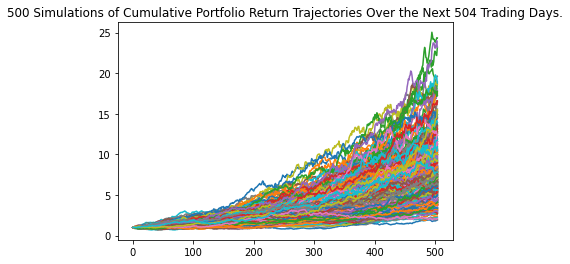

In [6]:
MC_2years = MCSimulation(
    portfolio_data = crypto_df,
    weights = "",
    num_simulation = 500,
    num_trading_days = 252*2
)
MC_2years.plot_simulation()

In [7]:
MC_2years.portfolio_data["XLM-USD"].head()

,Open,High,Low,Close,Adj Close,Volume,daily_return
Date,,,,,,,
2018-07-07,0.206104,0.209379,0.200413,0.208450,0.208450,36238600,NaN
2018-07-08,0.208953,0.216208,0.207633,0.209783,0.209783,40958600,0.006395
2018-07-09,0.210637,0.213485,0.206826,0.207929,0.207929,38649000,-0.008838
2018-07-10,0.206595,0.207311,0.191603,0.191889,0.191889,36923400,-0.077142
2018-07-11,0.191825,0.194245,0.184680,0.189504,0.189504,33530700,-0.012429


In [57]:
for key in range_of_cryptos:
    crypto_df = crypto_df.drop(index=key, columns=['Open','High','Low','Adj Close','Volume'], axis=1)


KeyError: "['BTC-USD'] not found in axis"